# Neural Network Text Classifier
We explore a few variants of NN classifiers using word embeddings:
<ul>
<li>Perceptron with Bag-of-words encoding</li>
<li>Perceptron with word embeddings</li>
<li>Perceptron with pretrained word embeddings</li>
<li>Convolutional Neural Network with pretrained word embeddings</li>
</ul>
Adapted from code at https://colab.research.google.com/github/kenperry-public/ML_Fall_2019/blob/master/Keras_examples_imdb_cnn.ipynb

## Import modules

In [1]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Input, Flatten, Lambda
from tensorflow.keras.layers import Embedding
import numpy as np

2023-03-13 15:08:34.673077: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-13 15:08:34.824703: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-03-13 15:08:34.824734: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-03-13 15:08:35.730029: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directo

### Set parameters

In [2]:
max_num_words = 10000
maxlen = 200    # max sentence length
batch_size = 32
embedding_dims = 50
hidden_dims = 250
VALIDATION_SPLIT = 0.1
epochs = 5

## Loading data

We will use the `Movie Review dataset` from https://www.kaggle.com/pankrzysiu/keras-imdb.
It contains 50,000 highly polarized reviews, preprocessed, tokenized, indexed and stored into numpy arrays.

By convention, index 0 is reserved for padding, 1 for start, 2 for unknown, hence set `index_from=3`.

In [3]:
from keras.datasets import imdb

(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=max_num_words, index_from=3)
print(len(x_train), 'train sequences')
print(len(x_test), 'test sequences')

25000 train sequences
25000 test sequences


In [4]:
help(imdb.load_data)

Help on function load_data in module keras.datasets.imdb:

load_data(path='imdb.npz', num_words=None, skip_top=0, maxlen=None, seed=113, start_char=1, oov_char=2, index_from=3, **kwargs)
    Loads the [IMDB dataset](https://ai.stanford.edu/~amaas/data/sentiment/).
    
    This is a dataset of 25,000 movies reviews from IMDB, labeled by sentiment
    (positive/negative). Reviews have been preprocessed, and each review is
    encoded as a list of word indexes (integers).
    For convenience, words are indexed by overall frequency in the dataset,
    so that for instance the integer "3" encodes the 3rd most frequent word in
    the data. This allows for quick filtering operations such as:
    "only consider the top 10,000 most
    common words, but eliminate the top 20 most common words".
    
    As a convention, "0" does not stand for a specific word, but instead is used
    to encode the pad token.
    
    Args:
      path: where to cache the data (relative to `~/.keras/dataset`).
  

Show one example

In [5]:
x_train[0][:10]

[1, 14, 22, 16, 43, 530, 973, 1622, 1385, 65]

Recover the words from the word index:

In [6]:
word_index = imdb.get_word_index()
print(f'Found {len(word_index)} unique tokens.')

Found 88584 unique tokens.


Keep just the `max_num_words` most frequent:

In [7]:
# load_data has assigned indexes 0, 1, 2 to (<PAD>, <START>, <UNK>) so load_data assigns the rank 0 word to index 3
word_index = { w:(k+3) for w,k in word_index.items() if k < max_num_words}
word_index['<PAD>'] = 0
word_index['<START>'] = 1
word_index['<UNK>'] = 2

num_words = len(word_index)

Reverse map: index to word

In [8]:
index_words = {i:w for w,i in word_index.items()}

In [9]:
' '.join([index_words[i] for i in x_train[2]])

"<START> this has to be one of the worst films of the 1990s when my friends i were watching this film being the target audience it was aimed at we just sat watched the first half an hour with our jaws touching the floor at how bad it really was the rest of the time everyone else in the theatre just started talking to each other leaving or generally crying into their popcorn that they actually paid money they had <UNK> working to watch this feeble excuse for a film it must have looked like a great idea on paper but on film it looks like no one in the film has a clue what is going on crap acting crap costumes i can't get across how <UNK> this is to watch save yourself an hour a bit of your life"

Remove the spurious `<br>` tokens from HTML.

In [10]:
br = word_index['br']
x_train = [[w for w in r if w != br] for r in x_train]
x_test = [[w for w in r if w != br] for r in x_test]

Pad sequences to `maxlen`.
Padding can be done either at the front or at the end of sentences, depending on the parametere `padding`.

In [11]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
x_train = pad_sequences(x_train, maxlen=maxlen, padding='post', truncating='post')
x_test = pad_sequences(x_test, maxlen=maxlen, padding='post', truncating='post')
print('x_train shape:', x_train.shape)
print('x_test shape:', x_test.shape)

x_train shape: (25000, 200)
x_test shape: (25000, 200)


In [12]:
' '.join([index_words[i] for i in x_train[2]])

"<START> this has to be one of the worst films of the 1990s when my friends i were watching this film being the target audience it was aimed at we just sat watched the first half an hour with our jaws touching the floor at how bad it really was the rest of the time everyone else in the theatre just started talking to each other leaving or generally crying into their popcorn that they actually paid money they had <UNK> working to watch this feeble excuse for a film it must have looked like a great idea on paper but on film it looks like no one in the film has a clue what is going on crap acting crap costumes i can't get across how <UNK> this is to watch save yourself an hour a bit of your life <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD

### Split train data into train and validation:

In [13]:
indices = np.arange(x_train.shape[0])
np.random.shuffle(indices)
data = x_train[indices]
labels = y_train[indices]
nb_validation_samples = int(VALIDATION_SPLIT * data.shape[0])

x_train = data[:-nb_validation_samples]
y_train = labels[:-nb_validation_samples]
x_val = data[-nb_validation_samples:]
y_val = labels[-nb_validation_samples:]

x_train.shape, y_train.shape, x_val.shape, y_val.shape, x_test.shape, y_test.shape

((22500, 200), (22500,), (2500, 200), (2500,), (25000, 200), (25000,))

## Perceptron with Bag-of-words representations

*Build a NN binary classifier in Keras using the following layers:*
1. one-hot input representation
2. Sum the vectors into a BOW vexctor
4. Dense

*and a cross-entropy loss function.
You may use pretrained GLoVE embeddings from:*
http://medialab.di.unipi.it/jupyterhub/notebooks/HLT/data/glove.6B/glove.first-100k.6B.50d.txt

In [14]:
model_bow = Sequential()

2023-03-13 15:08:59.377711: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2023-03-13 15:08:59.377745: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2023-03-13 15:08:59.377774: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (medialab): /proc/driver/nvidia/version does not exist
2023-03-13 15:08:59.378056: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


This is NOT a real embedding layer, it is just a **trick 
to convert words into one-hot representations**.

Note that the embeddings are not trained, they are not updates during training, as specified by `trainable=False`.

In [15]:
model_bow.add(Embedding(num_words,
                    num_words,
                    embeddings_initializer='identity', # one-hot representation
                    input_length=maxlen,
                    trainable=False))  # do not train the embeddings

Add the one-hot vectors for all words into a single BOW vector:

In [16]:
import tensorflow as tf
model_bow.add(Lambda(lambda x: tf.math.reduce_sum(x, axis=1))) # axis=0 is batch

We project onto a single unit output layer, and squash it with a sigmoid:

In [17]:
model_bow.add(Dense(1, activation='sigmoid'))

## Compile the model
`Keras` is built on top `TensorFlow`. Tensorflow allows you to define a computation graph in `Python`, which is then compiled and run efficiently on the CPU or GPU without the overhead of the Python interpreter.

The `compile` method takes three arguments:
- A loss function. The objective that the model will try to minimize. It can be the name of an existing loss function (such as `categorical_crossentropy` or ` mse`), or it can be an objective function.
- An optimizer. The name of an existing optimizer (such as `rmsprop`, `adagrad` or 'adam`), or an instance of the Optimizer class.
- A list of metrics. For any classification problem you will want to set this to `metrics=['accuracy']`. A metric could be the name of an existing metric or a custom metric function.

`Adam` optimization is a stochastic gradient descent method based on adaptive estimation of first-order and second-order moments.

In [18]:
model_bow.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

### Show model

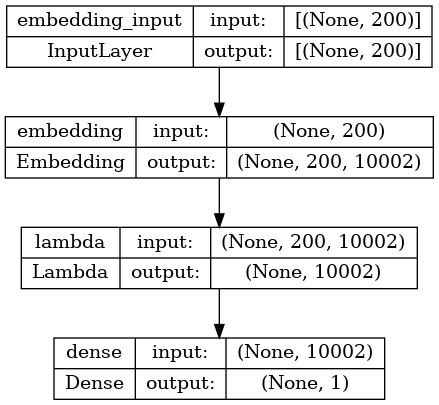

In [19]:
from tensorflow.keras.utils import plot_model

plot_model(model_bow, show_shapes=True)

### Train the model

In [20]:
history_bow = model_bow.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          validation_data=(x_val, y_val))

Epoch 1/5
704/704 [==============================] - 70s 99ms/step - loss: 0.4681 - accuracy: 0.8054 - val_loss: 0.3761 - val_accuracy: 0.8592
Epoch 2/5
704/704 [==============================] - 73s 104ms/step - loss: 0.3195 - accuracy: 0.8864 - val_loss: 0.3328 - val_accuracy: 0.8712
Epoch 3/5
704/704 [==============================] - 67s 95ms/step - loss: 0.2711 - accuracy: 0.9059 - val_loss: 0.3156 - val_accuracy: 0.8728
Epoch 4/5
704/704 [==============================] - 66s 93ms/step - loss: 0.2416 - accuracy: 0.9173 - val_loss: 0.3064 - val_accuracy: 0.8748
Epoch 5/5
704/704 [==============================] - 65s 92ms/step - loss: 0.2201 - accuracy: 0.9252 - val_loss: 0.3096 - val_accuracy: 0.8700


### Evaluate
Evaluate on the test set.

In [21]:
loss, accuracy = model_bow.evaluate(x_test, y_test, verbose=False)
print(f"Testing Accuracy:  {accuracy:.4f}")

Testing Accuracy:  0.8589


### Visualize training history

In [22]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')

def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training acc')
    plt.plot(x, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

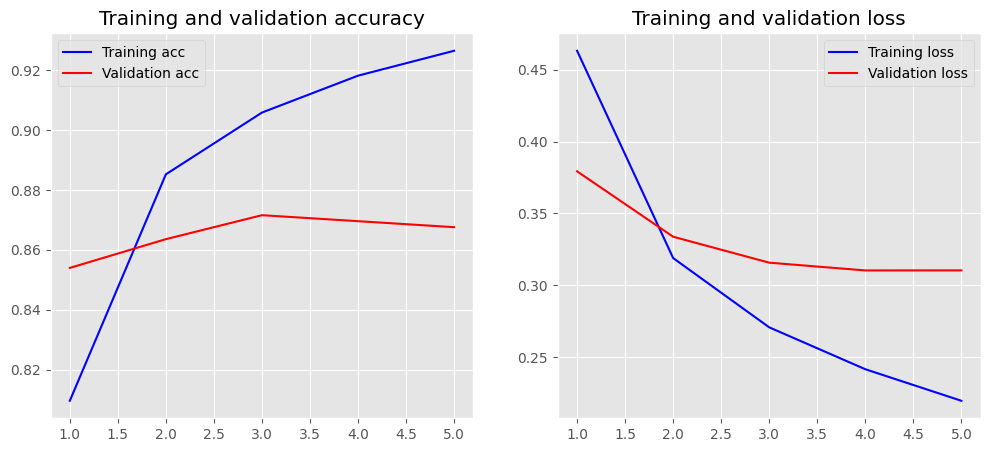

In [23]:
plot_history(history_bow)

## Perceptron with Word Embeddings

In [22]:
model = Sequential()

We start off with an efficient embedding layer which maps
our vocab indices into `embedding_dims` dimensions,
initialized to random values.

In [23]:
model.add(Embedding(num_words,
                    embedding_dims,
                    embeddings_initializer='random_uniform',
                    input_length=maxlen))

Concatenate the vectors of all input words:

In [24]:
model.add(Flatten())

Add a hidden layer with a single unit output, and squash it with a sigmoid:

In [25]:
model.add(Dense(1, activation='sigmoid'))

Compile the model:

In [26]:
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['binary_accuracy'])

### Show the model

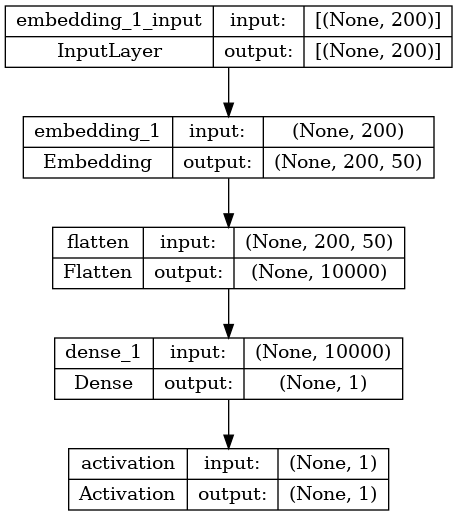

In [27]:
plot_model(model, show_shapes=True)

### Training

In [ ]:
history = model.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          validation_data=(x_val, y_val))

Epoch 1/5


### Testing

In [197]:
predictions = model.predict(x_test)

782/782 [==============================] - 1s 1ms/step


In [198]:
predictions[:10]

array([[0.36423203],
       [0.99998707],
       [0.9724861 ],
       [0.66624993],
       [0.9808393 ],
       [0.45665017],
       [0.3749947 ],
       [0.01410616],
       [0.9960725 ],
       [0.6432735 ]], dtype=float32)

In [199]:
predictions.round()[:10]

array([[0.],
       [1.],
       [1.],
       [1.],
       [1.],
       [0.],
       [0.],
       [0.],
       [1.],
       [1.]], dtype=float32)

See the correct results

In [200]:
y_test[:10]

array([0, 1, 1, 0, 1, 1, 1, 0, 0, 1])

Compare predictions with the correct results

In [201]:
errors = y_test - predictions.round().flatten()
errors

array([ 0.,  0.,  0., ...,  0.,  0., -1.])

In [202]:
len(errors[errors==0])

21225

In [203]:
len(errors[errors==0])/len(errors)

0.849

### Evaluation

In [1]:
loss, accuracy = model.evaluate(x_test, y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))

NameError: name 'model' is not defined

Plot the accuracy through the epochs

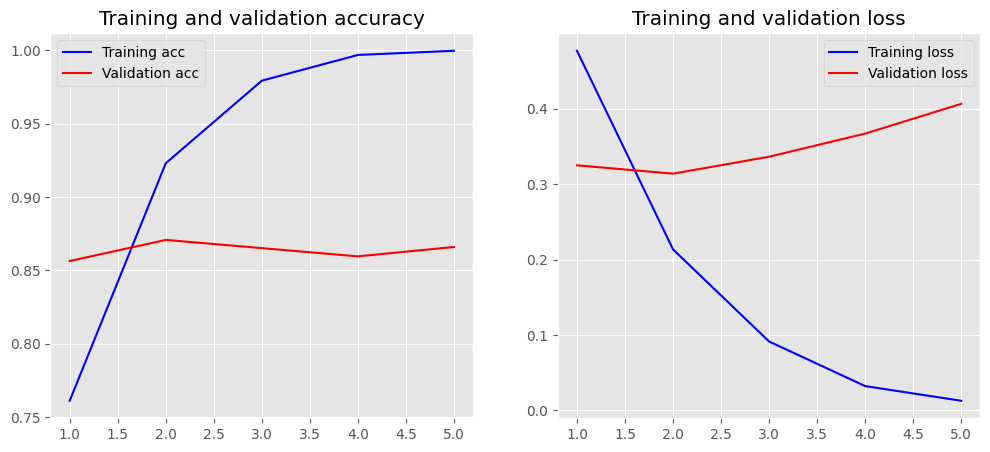

In [39]:
plot_history(history)

## Exploring the fine-tuned embeddings
The model has 4 layers:

In [40]:
model.layers

The first layer is the embeddings layer:

In [41]:
embeddings = model.get_weights()[0]
embeddings.shape

(10002, 50)

Let's see the embeddings for one word:

In [42]:
embeddings[1]

array([ 1.85650497e-04, -5.59149560e-10, -3.32006202e-05, -5.70465719e-33,
        1.86644599e-03,  7.42030534e-29,  4.57352698e-08,  1.84298193e-12,
       -1.19911038e-17, -1.21035313e-07,  1.59978242e-09, -1.84946430e-06,
       -2.49342776e-33,  7.22757959e-23, -1.32315436e-10, -8.80099600e-04,
        1.08337042e-32, -2.66813237e-04, -1.36923612e-04, -9.77981528e-17,
       -4.20990371e-33,  5.72724812e-19,  2.62330347e-20,  4.45327641e-09,
       -2.74506519e-31,  1.48975892e-06, -3.56537149e-25, -1.39446354e-11,
        7.03849638e-17, -3.63840485e-07,  4.35532968e-18, -5.96663851e-33,
        4.27616015e-03, -3.39936116e-04,  2.86056864e-04,  5.42184664e-03,
       -9.54339339e-06, -1.24277325e-30,  1.14035085e-02,  1.72785430e-12,
       -6.40601793e-04, -7.17512421e-06,  1.94912061e-33, -2.18595644e-21,
        2.64868705e-33, -5.10113430e-04,  2.11764379e-18,  1.12215051e-33,
        9.60418582e-03,  1.56819895e-32], dtype=float32)

Similarty between two words (for cosine we should divide by their length):

In [43]:
def cosine(x, y):
    return x.dot(y)/(np.linalg.norm(x) * np.linalg.norm(y))

In [44]:
cosine(embeddings[word_index['film']], embeddings[word_index['films']])

0.091205046

### Evaluation

In [45]:
loss, accuracy = model.evaluate(x_test, y_test, verbose=False)
print(f"Testing Accuracy:  {accuracy:.4f}")

Testing Accuracy:  0.8472


### Explore
Experiment yourself, by increasing the number of epochs, adding layers, etc

For example, add an hidden layer and a dropout:

## Pretrained embeddings

Load GloVe embeddings

In [22]:
#import gensim.downloader as dl
#glove_embeddings = dl.load('glove-wiki-gigaword-50') # glove-twitter-25
#glove_dims = glove_embeddings.vector_size

def load_embeddings(file):
    embeddings = dict()
    with open(file) as f:
        for line in f:
            records = line.split()
            word = records[0]
            vector = np.asarray(records[1:], dtype='float32')
            embeddings[word] = vector
    return embeddings

glove_embeddings = load_embeddings('../data/glove.6B/glove.6B.50d.txt')
glove_dims = len(next(iter(glove_embeddings.items()))[1])

Create a matrix with embeddings for words in the index

Initialize with random weights, to handle OOV words

In [23]:
import numpy as np
word_embeddings = np.random.uniform(-0.2, 0.2, (num_words, glove_dims))

Store embeddings for known words:

In [24]:
for word, i in word_index.items():
    if i >= num_words:
        continue
    if word in glove_embeddings:
        # words not found in embeddings will have random weights
        word_embeddings[i] = glove_embeddings[word]

### Perceptron Model with Pretrained Word Embeddings

In [166]:
model_glove = Sequential()

We now use an embedding layer using the embeddings from GloVe.

We set `trainable=True` in order to get these embbedding to be tuned during the training.<br/>
If we use `trainable=False`, the embedggings will remain unchanged.<br/>
You may want to see what difference this could make to the accuracy of the model.

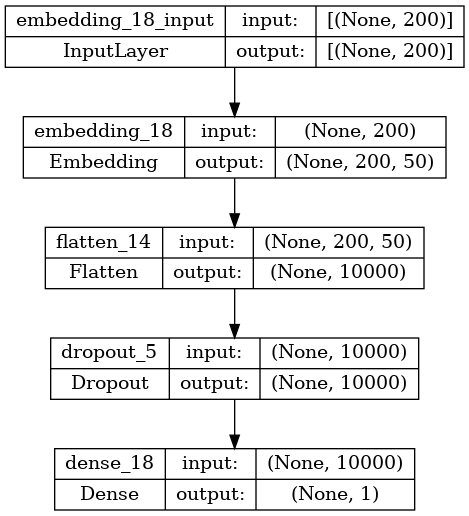

In [167]:
model_glove.add(Embedding(word_embeddings.shape[0],
                    word_embeddings.shape[1], 
                    weights=[word_embeddings], 
                    input_length=maxlen, 
                    trainable=True))
model_glove.add(Flatten())
model_glove.add(Dropout(0.10)) # second layer
model_glove.add(Dense(1, activation='sigmoid')) # second layer
model_glove.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

plot_model(model_glove, show_shapes=True)

### Train the model

In [168]:
history_glove = model_glove.fit(x_train, y_train,
                    epochs=epochs,
                    validation_data=(x_val, y_val),
                    batch_size=batch_size)

Epoch 1/5
704/704 [==============================] - 6s 8ms/step - loss: 0.5872 - accuracy: 0.6947 - val_loss: 0.4798 - val_accuracy: 0.7820
Epoch 2/5
704/704 [==============================] - 5s 8ms/step - loss: 0.3480 - accuracy: 0.8508 - val_loss: 0.4796 - val_accuracy: 0.7948
Epoch 3/5
704/704 [==============================] - 5s 7ms/step - loss: 0.2291 - accuracy: 0.9131 - val_loss: 0.5421 - val_accuracy: 0.7940
Epoch 4/5
704/704 [==============================] - 5s 7ms/step - loss: 0.1456 - accuracy: 0.9492 - val_loss: 0.4631 - val_accuracy: 0.8264
Epoch 5/5
704/704 [==============================] - 5s 7ms/step - loss: 0.0946 - accuracy: 0.9724 - val_loss: 0.4896 - val_accuracy: 0.8256


### Evaluate

Training Accuracy: 0.9935
Testing Accuracy:  0.8173


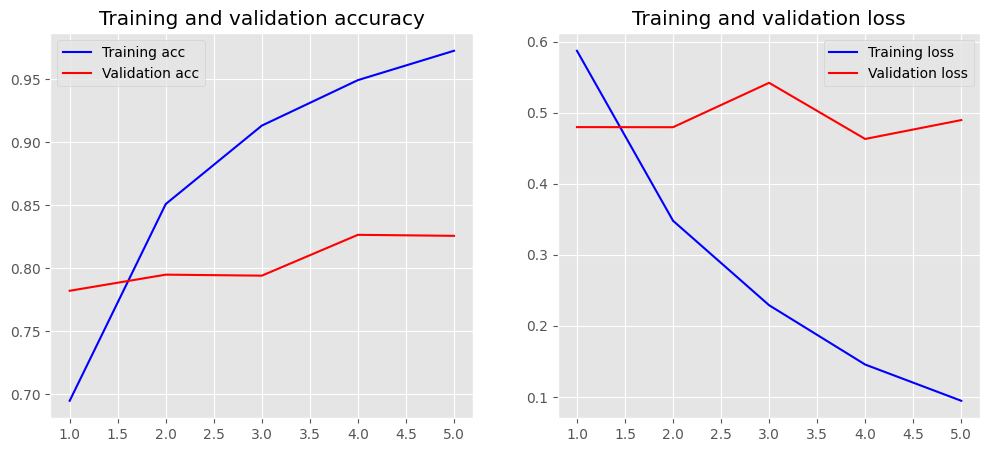

In [169]:
loss, accuracy = model_glove.evaluate(x_train, y_train, verbose=False)
print(f"Training Accuracy: {accuracy:.4f}")
loss, accuracy = model_glove.evaluate(x_test, y_test, verbose=False)
print(f"Testing Accuracy:  {accuracy:.4f}")
plot_history(history_glove)

## Convolutional Neural Network

We use GloVe embeddings in the first layer.

In [25]:
word_embeddings = np.random.uniform(-0.2, 0.2, (num_words, glove_dims))
for word, i in word_index.items():
    if i >= num_words:
        continue
    if word in glove_embeddings:
        # words not found in embeddings will have random weights
        word_embeddings[i] = glove_embeddings[word]

In [26]:
model_cnn = Sequential()
model_cnn.add(Embedding(word_embeddings.shape[0],
                        word_embeddings.shape[1], 
                        weights=[word_embeddings], 
                        input_length=maxlen))

In [27]:
model_cnn.add(Dropout(0.5))

We add a convolution layer with MaxPooling.

The next figure illustrates how such a convolution works. It starts by taking a pool of input vectors of the given `pool_size`. These vectors are reduced to a single vector, in the case of `MaxPooling1D` by taking the largest value along each dimension.

<img src='../image/MaxPooling1D.jpg'>

In [28]:
filters = 200
pool_size = 7
from tensorflow.keras.layers import GlobalMaxPooling1D, Conv1D

model_cnn.add(Conv1D(filters,           # output size
                     pool_size,         # width of convolution window
                     padding="valid",   # "valid" means "no padding"
                     activation="relu", # Rectified Linear Unit
                     strides=1))        # consecutive, no gaps

We use max pooling:

In [29]:
model_cnn.add(GlobalMaxPooling1D())

We add a vanilla hidden layer:

In [30]:
model_cnn.add(Dense(embedding_dims, activation="relu"))
model_cnn.add(Dropout(0.5))

We project onto a single unit output layer, and squash it with a sigmoid:

In [31]:
model_cnn.add(Dense(1, activation="sigmoid", name="predictions"))

model_cnn.compile(optimizer='adam',
                  loss='binary_crossentropy',
                  metrics=['accuracy'])

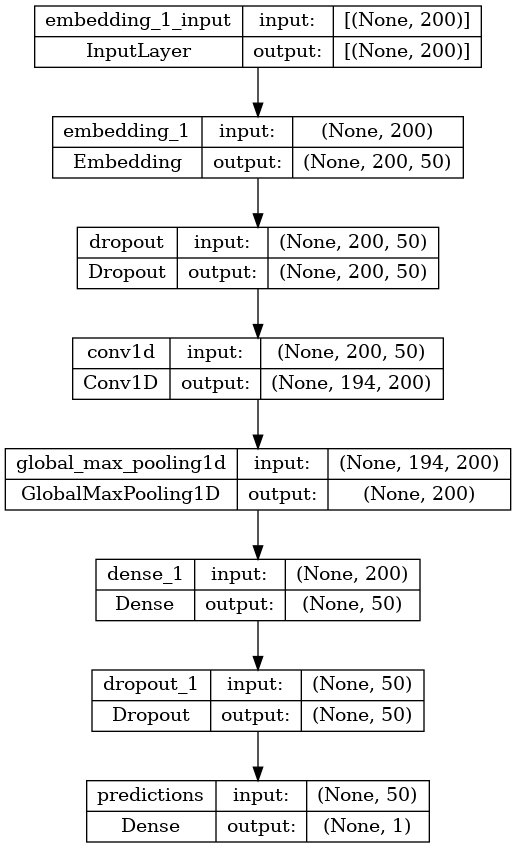

In [32]:
plot_model(model_cnn, show_shapes=True)

### Train the model

This will take longer, ...

In [33]:
history_cnn = model_cnn.fit(x_train, y_train,
                    epochs=epochs,
                    validation_data=(x_val, y_val),
                    batch_size=batch_size)

Epoch 1/5
704/704 [==============================] - 40s 55ms/step - loss: 0.6580 - accuracy: 0.5849 - val_loss: 0.4952 - val_accuracy: 0.7928
Epoch 2/5
704/704 [==============================] - 38s 54ms/step - loss: 0.4830 - accuracy: 0.7749 - val_loss: 0.3681 - val_accuracy: 0.8328
Epoch 3/5
704/704 [==============================] - 38s 54ms/step - loss: 0.4083 - accuracy: 0.8222 - val_loss: 0.3322 - val_accuracy: 0.8556
Epoch 4/5
704/704 [==============================] - 31s 44ms/step - loss: 0.3741 - accuracy: 0.8411 - val_loss: 0.3115 - val_accuracy: 0.8692
Epoch 5/5
704/704 [==============================] - 21s 30ms/step - loss: 0.3447 - accuracy: 0.8540 - val_loss: 0.3154 - val_accuracy: 0.8620


### Evaluate

Training Accuracy: 0.9079
Testing Accuracy:  0.8650


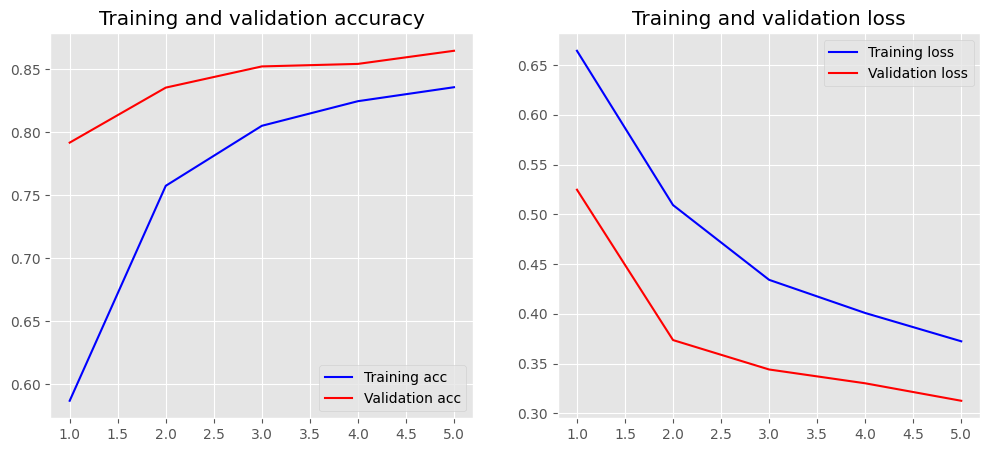

In [180]:
loss, accuracy = model_cnn.evaluate(x_train, y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model_cnn.evaluate(x_test, y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))
plot_history(history_cnn)